In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import matplotlib.pyplot as plt
import datetime
import random
import numpy as np
import os
import pickle
from google.colab import drive

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

CNPRegressionDescription = collections.namedtuple(
    "CNPRegressionDescription", ("query", "target_y")
)
class FunctionFamily:
    SINE = "sine"
    EXP = "exp"
    POLYNOMIAL = "polynomial"
    STRAIGHT_LINE = "straight_line"

class CurvesReader:
    """Generates curves from various function families with mixed sampling."""

    def __init__(self, batch_size, max_num_context, testing=False):
        self._batch_size = batch_size
        self._max_num_context = max_num_context
        self._testing = testing
        self._function_families = [
            FunctionFamily.SINE,
            FunctionFamily.EXP,
            FunctionFamily.POLYNOMIAL,
            FunctionFamily.STRAIGHT_LINE,
        ]

    def generate_curves(self, function_family=None):
        """Builds the op delivering the data with mixed function families."""

        # Sample number of context points
        num_context = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))

        if self._testing:
            num_target = 400
            num_total_points = num_target
            x_values = torch.linspace(start=-2, end=2, steps=num_target).unsqueeze(0).repeat(self._batch_size, 1).unsqueeze(-1)
        else:
            num_target = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))
            num_total_points = num_context + num_target
            x_values = (torch.rand((self._batch_size, num_total_points, 1))) * 4 - 2  # unif[-2, 2]

        # Randomly select function family if not specified
        if function_family is None:
            function_family = random.choice(self._function_families)

        # Generate different function types with random parameters
        if function_family == FunctionFamily.SINE:
            # Random amplitude (0.5-1.5), frequency (0.5-2.5), phase (0-2pi)
            amplitude = torch.rand(1) + 0.5
            frequency = torch.rand(1) * 2 + 0.5
            phase = torch.rand(1) * 2 * np.pi
            y_values = amplitude * torch.sin(frequency * x_values + phase)

        elif function_family == FunctionFamily.EXP:
            # Random scale (-0.5 to 0.5) and shift (-1 to 1)
            scale = torch.rand(1) - 0.5
            shift = torch.rand(1) * 2 - 1
            y_values = torch.exp(scale * x_values) + shift

        elif function_family == FunctionFamily.POLYNOMIAL:
            # Random quadratic coefficients (-1 to 1)
            coeffs = torch.rand(3) * 2 - 1
            y_values = coeffs[0] + coeffs[1] * x_values + coeffs[2] * x_values**2

        elif function_family == FunctionFamily.STRAIGHT_LINE:
            # Random slope (-1 to 1) and intercept (-2 to 2)
            slope = torch.rand(1) * 2 - 1
            intercept = torch.rand(1) * 4 - 2
            y_values = slope * x_values + intercept
        else:
            raise ValueError(f"Unknown function family: {function_family}")

        # Split into context and target points
        if self._testing:
            target_x = x_values
            target_y = y_values
            idx = torch.randperm(num_target)
            context_x = x_values[:, idx[:num_context], :]
            context_y = y_values[:, idx[:num_context], :]
        else:
            target_x = x_values[:, : num_target + num_context, :]
            target_y = y_values[:, : num_target + num_context, :]
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]

        query = ((context_x, context_y), target_x)
        return CNPRegressionDescription(query=query, target_y=target_y), function_family

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Mount Google Drive (for saving datasets persistently)
drive.mount('/content/drive')


# Function families
class FunctionFamily:
    SINE = "sine"
    EXP = "exp"
    POLYNOMIAL = "polynomial"
    STRAIGHT_LINE = "straight_line"

function_families = [
    FunctionFamily.SINE,
    FunctionFamily.EXP,
    FunctionFamily.POLYNOMIAL,
    FunctionFamily.STRAIGHT_LINE,
]

# Dataset configuration
DATASET_NAME = "fixed_cnp_dataset.pkl"  # Single file for all datasets
DATASET_PATH = f"/content/drive/MyDrive/{DATASET_NAME}"

# =============================================
# Dataset Management
# =============================================
def generate_fixed_datasets():
    """Generate new fixed datasets for all function families"""
    print("Generating new fixed datasets...")

    test_readers = {
        family: CurvesReader(TEST_BATCH_SIZE, MAX_CONTEXT_POINTS, testing=True)
        for family in function_families
    }

    fixed_datasets = {}
    for family in function_families:
        fixed_datasets[family] = [
            test_readers[family].generate_curves(family)[0]
            for _ in range(NUM_TEST_TASKS)
        ]
        print(f"Generated {len(fixed_datasets[family])} tasks for {family}")

    return fixed_datasets

def save_datasets(datasets):
    """Save datasets to Google Drive"""
    with open(DATASET_PATH, 'wb') as f:
        pickle.dump({
            'creation_date': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'parameters': {
                'test_batch_size': TEST_BATCH_SIZE,
                'max_context_points': MAX_CONTEXT_POINTS,
                'num_test_tasks': NUM_TEST_TASKS
            },
            'data': datasets
        }, f)
    print(f"Saved fixed datasets to {DATASET_PATH}")

def load_datasets():
    """Load datasets from Google Drive"""
    if not os.path.exists(DATASET_PATH):
        return None

    with open(DATASET_PATH, 'rb') as f:
        data = pickle.load(f)
        print(f"Loaded fixed datasets created on {data['creation_date']}")
        return data['data']

# Load or create fixed datasets
fixed_test_datasets = load_datasets()

if fixed_test_datasets is None:
    fixed_test_datasets = generate_fixed_datasets()
    save_datasets(fixed_test_datasets)
else:
    print("Using existing fixed datasets")


MessageError: Error: credential propagation was unsuccessful

In [ ]:
# Dataset configuration
DATASET_NAME = "fixed_cnp_dataset.pkl"  # Single file for all datasets
DATASET_PATH = f"/content/{DATASET_NAME}"
# =============================================
def generate_fixed_datasets():
    """Generate new fixed datasets for all function families"""
    print("Generating new fixed datasets...")

    test_readers = {
        family: CurvesReader(TEST_BATCH_SIZE, MAX_CONTEXT_POINTS, testing=True)
        for family in function_families
    }

    fixed_datasets = {}
    for family in function_families:
        fixed_datasets[family] = [
            test_readers[family].generate_curves(family)[0]
            for _ in range(NUM_TEST_TASKS)
        ]
        print(f"Generated {len(fixed_datasets[family])} tasks for {family}")

    return fixed_datasets

def save_datasets(datasets):
    """Save datasets to Google Drive"""
    with open(DATASET_PATH, 'wb') as f:
        pickle.dump({
            'creation_date': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'parameters': {
                'test_batch_size': TEST_BATCH_SIZE,
                'max_context_points': MAX_CONTEXT_POINTS,
                'num_test_tasks': NUM_TEST_TASKS
            },
            'data': datasets
        }, f)
    print(f"Saved fixed datasets to {DATASET_PATH}")

def load_datasets():
    """Load datasets from Google Drive"""
    if not os.path.exists(DATASET_PATH):
        return None

    with open(DATASET_PATH, 'rb') as f:
        data = pickle.load(f)
        print(f"Loaded fixed datasets created on {data['creation_date']}")
        return data['data']

# Load or create fixed datasets
fixed_test_datasets = load_datasets()

if fixed_test_datasets is None:
    fixed_test_datasets = generate_fixed_datasets()
    save_datasets(fixed_test_datasets)
else:
    print("Using existing fixed datasets")

Loaded fixed datasets created on 2025-04-13 19:09:56
Using existing fixed datasets


Starting training at 2025-04-14 15:05:09
Training for 100000 iterations with 100-iteration blocks
Training order: ['straight_line', 'polynomial', 'exp', 'sine']

Block 1: Training on straight_line

Block 2: Training on polynomial

Block 3: Training on exp

Block 4: Training on sine

Block 5: Training on straight_line

Evaluation at iteration 500 (Current family: straight_line):
  sine: MSE = 0.6346
  exp: MSE = 0.1516
  polynomial: MSE = 1.0873
  straight_line: MSE = 0.4256
Average MSE across all families: 0.5748

Block 6: Training on polynomial

Block 7: Training on exp

Block 8: Training on sine

Block 9: Training on straight_line

Block 10: Training on polynomial

Evaluation at iteration 1000 (Current family: polynomial):
  sine: MSE = 0.6018
  exp: MSE = 0.1508
  polynomial: MSE = 1.0581
  straight_line: MSE = 0.4192
Average MSE across all families: 0.5575

Block 11: Training on exp

Block 12: Training on sine

Block 13: Training on straight_line

Block 14: Training on polynomial



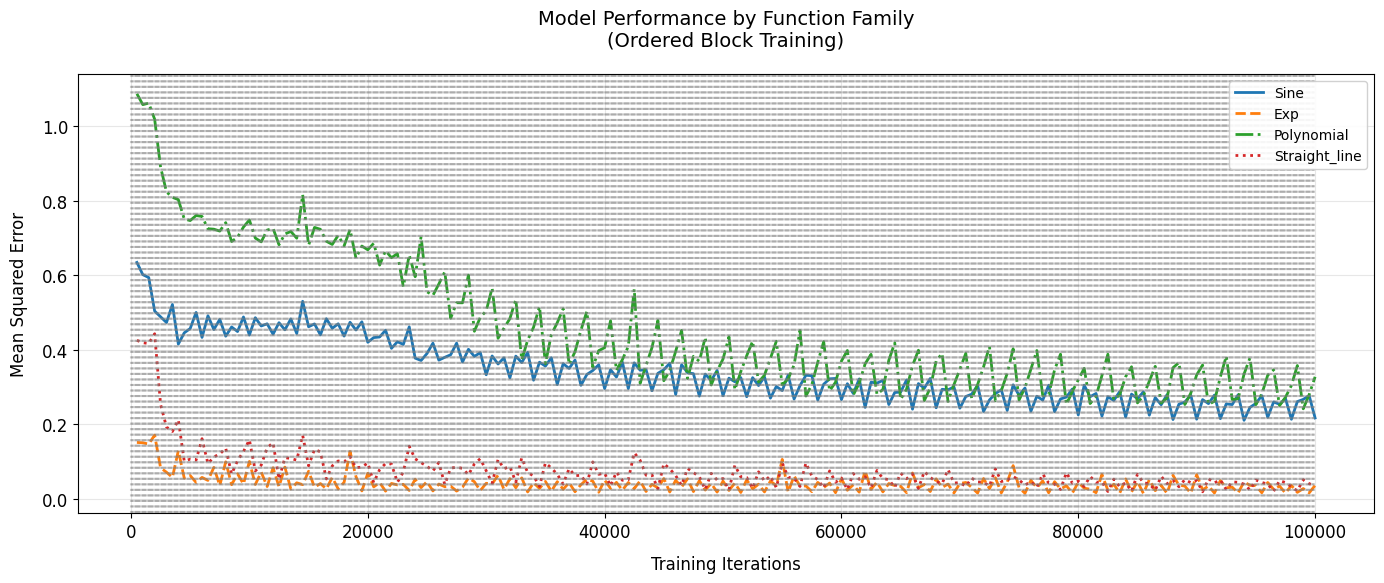

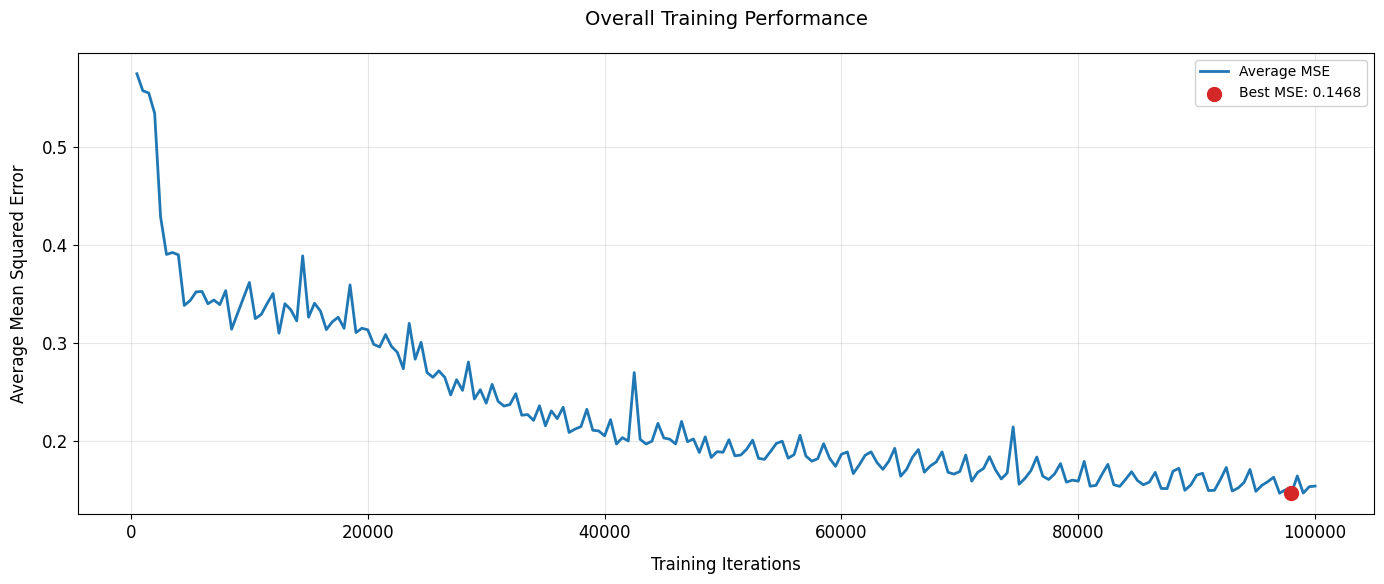


Final Evaluation:
  sine: MSE = 0.2174
sine test MSE: 0.2174


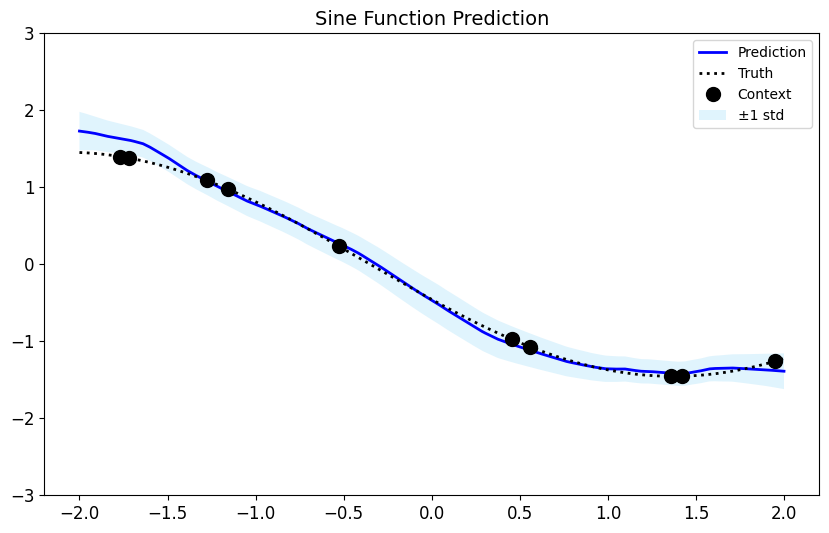

  exp: MSE = 0.0364
exp test MSE: 0.0364


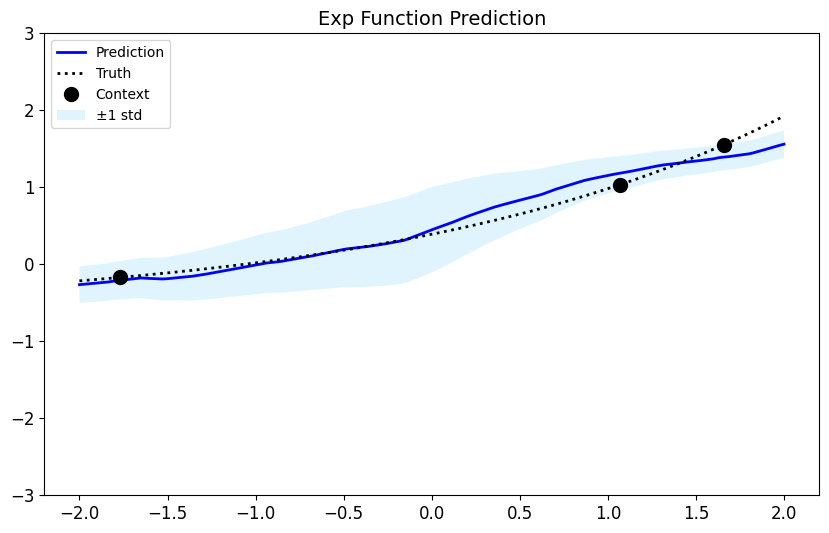

  polynomial: MSE = 0.3277
polynomial test MSE: 0.3277


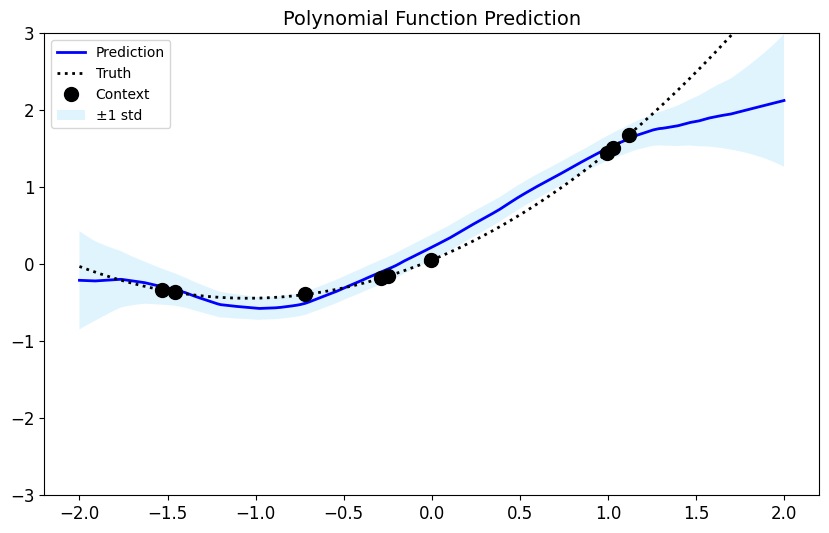

  straight_line: MSE = 0.0357
straight_line test MSE: 0.0357


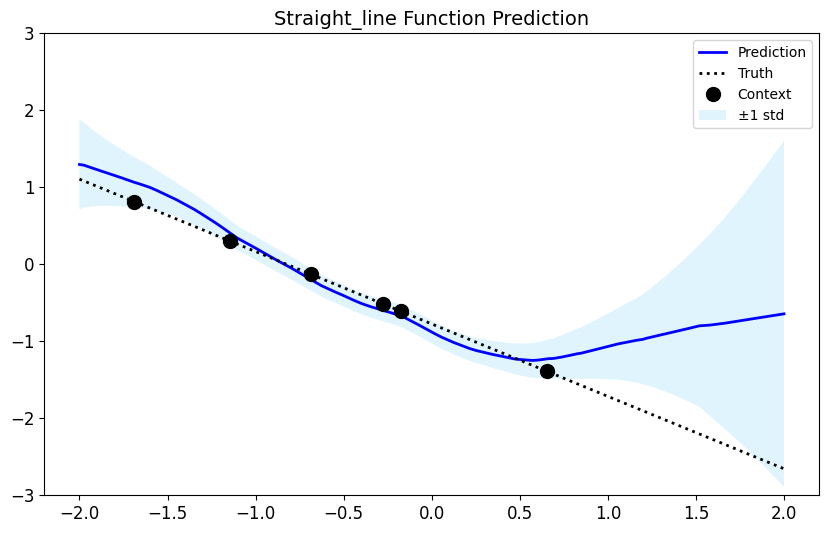

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import matplotlib.pyplot as plt
import datetime
import random
import numpy as np

class FunctionFamily:
    SINE = "sine"
    EXP = "exp"
    POLYNOMIAL = "polynomial"
    STRAIGHT_LINE = "straight_line"

function_families = [
    FunctionFamily.SINE,
    FunctionFamily.EXP,
    FunctionFamily.POLYNOMIAL,
    FunctionFamily.STRAIGHT_LINE,
]

class DeterministicEncoder(nn.Module):
    def __init__(self, sizes):
        super(DeterministicEncoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, context_x, context_y):
        encoder_input = torch.cat((context_x, context_y), dim=-1)
        batch_size, set_size, filter_size = encoder_input.shape
        x = encoder_input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        x = x.view(batch_size, set_size, -1)
        representation = x.mean(dim=1)
        return representation

class DeterministicDecoder(nn.Module):
    def __init__(self, sizes):
        super(DeterministicDecoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, representation, target_x):
        batch_size, set_size, d = target_x.shape
        representation = representation.unsqueeze(1).repeat([1, set_size, 1])
        input = torch.cat((representation, target_x), dim=-1)
        x = input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        out = x.view(batch_size, set_size, -1)
        mu, log_sigma = torch.split(out, 1, dim=-1)
        sigma = 0.1 + 0.9 * torch.nn.functional.softplus(log_sigma)
        dist = torch.distributions.normal.Normal(loc=mu, scale=sigma)
        return dist, mu, sigma

class DeterministicModel(nn.Module):
    def __init__(self, encoder_sizes, decoder_sizes):
        super(DeterministicModel, self).__init__()
        self._encoder = DeterministicEncoder(encoder_sizes)
        self._decoder = DeterministicDecoder(decoder_sizes)

    def forward(self, query, target_y=None):
        (context_x, context_y), target_x = query
        representation = self._encoder(context_x, context_y)
        dist, mu, sigma = self._decoder(representation, target_x)
        log_p = None if target_y is None else dist.log_prob(target_y)
        return log_p, mu, sigma

def plot_functions(target_x, target_y, context_x, context_y, pred_y, var, title=""):
    """Plots the predicted mean and variance and the context points."""
    plt.figure(figsize=(10, 6))
    plt.plot(target_x[0].squeeze(), pred_y[0].squeeze(), "b", linewidth=2, label='Prediction')
    plt.plot(target_x[0].squeeze(), target_y[0].squeeze(), "k:", linewidth=2, label='Truth')
    plt.plot(context_x[0].squeeze(), context_y[0].squeeze(), "ko", markersize=10, label='Context')
    plt.fill_between(
        target_x[0].squeeze(),
        (pred_y[0] - var[0]).squeeze(),
        (pred_y[0] + var[0]).squeeze(),
        alpha=0.2,
        facecolor="#65c9f7",
        interpolate=True,
        label='±1 std'
    )
    plt.legend()
    plt.ylim([-3, 3])
    plt.title(title)
    plt.show()

TRAINING_ITERATIONS = int(1e5)
BLOCK_SIZE = 100
EVAL_AFTER = 500
MAX_CONTEXT_POINTS = 10
BATCH_SIZE = 64
TEST_BATCH_SIZE = 100
NUM_TEST_TASKS = 100

# Model and Optimizer
d_x, d_in, representation_size, d_out = 1, 2, 128, 2
encoder_sizes = [d_in, 128, 128, 128, representation_size]
decoder_sizes = [representation_size + d_x, 128, 128, 2]
model = DeterministicModel(encoder_sizes, decoder_sizes)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training statistics
mse_values = []
training_blocks = []
family_mses = {family: [] for family in function_families}
current_family = None

def evaluate_model(model, test_datasets, family_name=None):
    """Evaluates the model on test datasets and returns average MSE."""
    model.eval()
    total_mse = 0.0
    with torch.no_grad():
        for data_test in test_datasets:
            _, pred_y, _ = model(data_test.query, data_test.target_y)
            mse = torch.mean((pred_y - data_test.target_y)**2)
            total_mse += mse.item()
    model.train()
    avg_mse = total_mse / len(test_datasets)

    if family_name is not None:
        print(f"  {family_name}: MSE = {avg_mse:.4f}")

    return avg_mse
# Training loop with ordered blocks
print(f"Starting training at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training for {TRAINING_ITERATIONS} iterations with {BLOCK_SIZE}-iteration blocks")

train_reader = CurvesReader(BATCH_SIZE, MAX_CONTEXT_POINTS, testing=False)

# Define the fixed order of function families
ordered_families = [
    FunctionFamily.STRAIGHT_LINE,
    FunctionFamily.POLYNOMIAL,
    FunctionFamily.EXP,
    FunctionFamily.SINE
]
print(f"Training order: {ordered_families}")

iterations_per_cycle = len(ordered_families) * BLOCK_SIZE

for it in range(TRAINING_ITERATIONS):
    # Determine current family based on ordered cycle
    cycle_position = it % iterations_per_cycle
    family_index = cycle_position // BLOCK_SIZE
    current_family = ordered_families[family_index]

    # Print when switching families (start of each block)
    if it % BLOCK_SIZE == 0:
        print(f"\nBlock {it // BLOCK_SIZE + 1}: Training on {current_family}")

    # Generate training batch from current family
    data_train, _ = train_reader.generate_curves(current_family)

    # Train step
    optimizer.zero_grad()
    log_prob, _, _ = model(data_train.query, data_train.target_y)
    loss = -log_prob.mean()
    loss.backward()
    optimizer.step()

    # Evaluation (every EVAL_AFTER iterations)
    if (it + 1) % EVAL_AFTER == 0:
        print(f"\nEvaluation at iteration {it + 1} (Current family: {current_family}):")
        current_mses = {}
        total_mse = 0.0

        # Evaluate on all function families
        for family in function_families:
            family_mse = evaluate_model(model, fixed_test_datasets[family], family)
            current_mses[family] = family_mse
            family_mses[family].append(family_mse)
            total_mse += family_mse

        # Record overall performance
        avg_mse = total_mse / len(function_families)
        mse_values.append(avg_mse)
        training_blocks.append(it + 1)

        print(f"Average MSE across all families: {avg_mse:.4f}")

# Plot training curves per family with vertical lines showing family boundaries
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 10

# Plot performance by function family
plt.figure(figsize=(14, 6))
# Use distinct line styles and colors
line_styles = ['-', '--', '-.', ':']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, family in enumerate(function_families):
    plt.plot(training_blocks, family_mses[family],
             label=family.capitalize(),
             linestyle=line_styles[i],
             color=colors[i],
             linewidth=2)

# Add vertical lines for family transitions
for block_start in range(0, TRAINING_ITERATIONS, BLOCK_SIZE):
    if block_start < training_blocks[-1]:
        plt.axvline(block_start, color='gray', linestyle=':', alpha=0.4)

plt.xlabel('Training Iterations', labelpad=10)
plt.ylabel('Mean Squared Error', labelpad=10)
plt.title('Model Performance by Function Family\n(Ordered Block Training)', pad=20)
plt.legend(framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot overall training performance
plt.figure(figsize=(14, 6))
plt.plot(training_blocks, mse_values,
         color='#1f77b4',
         linewidth=2,
         label='Average MSE')

# Highlight the best performance
best_mse = min(mse_values)
best_idx = mse_values.index(best_mse)
plt.scatter(training_blocks[best_idx], best_mse,
            color='#d62728',
            s=100,
            zorder=5,
            label=f'Best MSE: {best_mse:.4f}')

plt.xlabel('Training Iterations', labelpad=10)
plt.ylabel('Average Mean Squared Error', labelpad=10)
plt.title('Overall Training Performance', pad=20)
plt.legend(framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# Final evaluation and visualization
print("\nFinal Evaluation:")
test_reader = CurvesReader(1, MAX_CONTEXT_POINTS, testing=True)
for family in function_families:
    # Evaluate
    test_mse = evaluate_model(model, fixed_test_datasets[family], family)
    print(f"{family} test MSE: {test_mse:.4f}")

    # Visualize
    data_test, _ = test_reader.generate_curves(family)
    with torch.no_grad():
        _, pred_y, var = model(data_test.query, data_test.target_y)
        (context_x, context_y), target_x = data_test.query
        plot_functions(
            target_x.detach().numpy(),
            data_test.target_y.detach().numpy(),
            context_x.detach().numpy(),
            context_y.detach().numpy(),
            pred_y.detach().numpy(),
            var.detach().numpy(),
            title=f"{family.capitalize()} Function Prediction"
        )
